In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# To upload my Kaggle API key to fetch the Dataset
from google.colab import files
files.upload()

In [4]:
! mkdir ~/.kaggle

In [7]:
! cp kaggle.json ~/.kaggle/

In [8]:
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

 99% 2.28G/2.29G [00:18<00:00, 149MB/s]
100% 2.29G/2.29G [00:18<00:00, 132MB/s]


In [10]:
! unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [11]:
!rm -rf "/content/chest_xray/__MACOSX"

In [12]:
!rm -rf "/content/chest_xray/chest_xray"

In [59]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

In [60]:
# Reading and resizing the image using opencv
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [61]:
# Loading the Dataset
train = get_training_data('/content/chest_xray/train')
test = get_training_data('/content/chest_xray/test')
val = get_training_data('/content/chest_xray/val')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  app.launch_new_instance()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


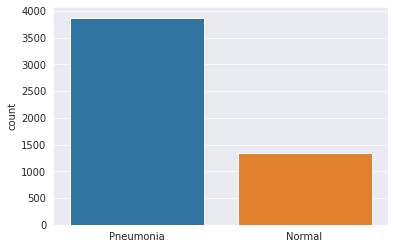

In [62]:
# Data Visualization
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)  

Text(0.5, 1.0, 'NORMAL')

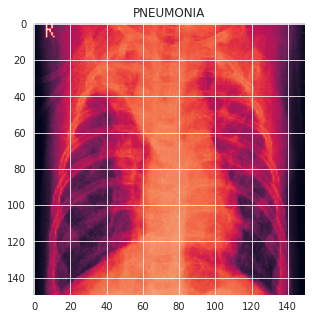

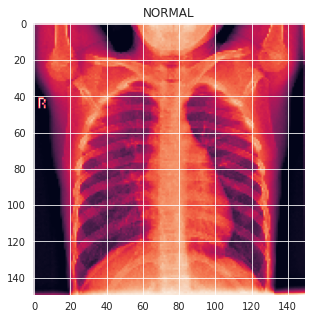

In [63]:
# Previewing the images of both the classes
plt.figure(figsize = (5,5))
plt.imshow(train[0][0]) # PNEUMONIA image
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0]) # NORMAL image
plt.title(labels[train[-1][1]])

In [64]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [65]:
# grayscale normalization to reduce the effect of illumination's differences.
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [66]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [67]:
# Data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180) -> 30 deg
        zoom_range = 0.2, # Randomly zoom image -> 20%
        width_shift_range = 0.1,  # randomly shift images horizontally (fraction of total width) -> 10%
        height_shift_range = 0.1,  # randomly shift images vertically (fraction of total height) -> 10%
        horizontal_flip = True,  # randomly flip images
        vertical_flip = False)  # randomly flip images

datagen.fit(x_train)

In [75]:
# Training the Model -> CNN

# 5 convolutional blocks comprised of convolutional layer, max-pooling and batch-normalization
# Dropouts -> to reduce overfitting
# 1 flatten layer and followed it by 1 Fully connected layers

# Activation function -> Relu (5 convolutional blocks)
# Activation function -> Sigmoid (Last layer) for binary classification

# Optimizer -> Root Mean Squared Propagation 
# Loss Function -> Binary Cross Entropy

model = Sequential()

# First conv block
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Second conv block
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Third conv block
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Fourth conv block
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# Fifth conv block
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

# FC layer
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

# Output Layer
model.add(Dense(units = 1 , activation = 'sigmoid'))

# Creating model and compiling
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_10 (Bat  (None, 150, 150, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_8 (Dropout)         (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_11 (Bat  (None, 75, 75, 64)      

In [83]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [84]:
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
163/163 [==============================] - 12s 73ms/step - loss: 0.0939 - accuracy: 0.9701 - val_loss: 0.4455 - val_accuracy: 0.8750 - lr: 2.7000e-05
Epoch 2/12
163/163 [==============================] - 11s 67ms/step - loss: 0.0807 - accuracy: 0.9711 - val_loss: 0.8655 - val_accuracy: 0.6250 - lr: 2.7000e-05
Epoch 3/12
163/163 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.9691
Epoch 3: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
163/163 [==============================] - 12s 71ms/step - loss: 0.0881 - accuracy: 0.9691 - val_loss: 2.2493 - val_accuracy: 0.5625 - lr: 2.7000e-05
Epoch 4/12
163/163 [==============================] - 11s 67ms/step - loss: 0.0908 - accuracy: 0.9703 - val_loss: 0.8771 - val_accuracy: 0.6875 - lr: 8.1000e-06
Epoch 5/12
163/163 [==============================] - ETA: 0s - loss: 0.0924 - accuracy: 0.9688
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
163/163 [==============

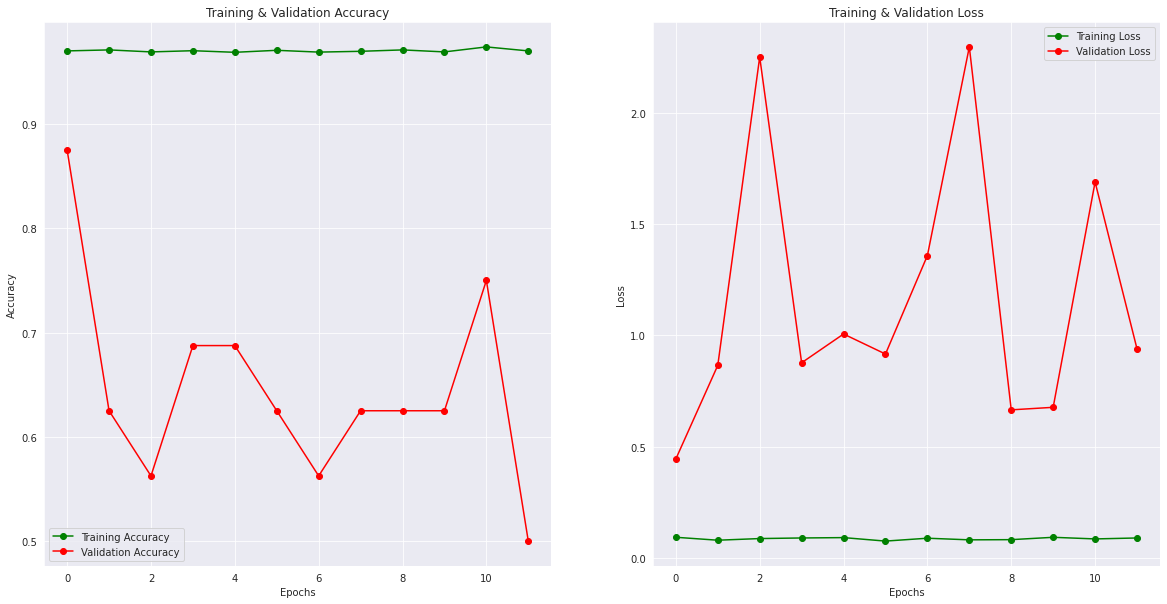

In [92]:
# Analysis after Model Training

epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [88]:
predictions = model.predict(x_test)
predictions = np.round(predictions)
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.90      0.91       390
   Normal (Class 1)       0.84      0.88      0.86       234

           accuracy                           0.89       624
          macro avg       0.89      0.89      0.89       624
       weighted avg       0.90      0.89      0.89       624



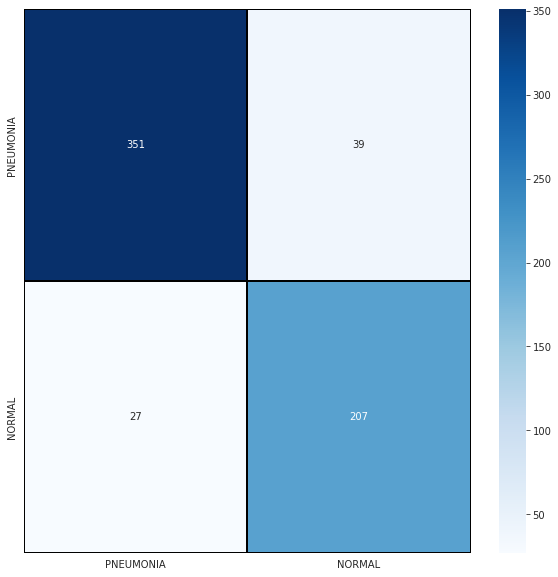

In [93]:
cm = confusion_matrix(y_test,predictions)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)